Below is select responses to exercises in 2020 Lopez de Prado book

Chapter 6
P value does not measure the probability that neither the null nor the alternative hypothesis is true, or that the data are random merely assuming it. And a p-value does not measure the size of an effect, or the significance of a result. Black swans are a thing so we should avoid using common use p-values. 

In [1]:
from sklearn.datasets import make_classification
import numpy as np,pandas as pd,seaborn as sns
import statsmodels.discrete.discrete_model as sm 
import warnings
warnings.filterwarnings("ignore")

def getTestData(n_features=100,n_informative=25,n_redundant=25, n_samples=10000,random_state=0,sigmaStd=.0):
# generate a random dataset for a classification problem
    np.random.seed(random_state) 
    X,y=make_classification(n_samples=n_samples,n_features=n_features-n_redundant, n_informative=n_informative,n_redundant=0,shuffle=False, random_state=random_state)
    cols=['I_'+str(i) for i in range(n_informative)] 
    cols= cols + ['N_'+str(i) for i in range(n_features-n_informative- n_redundant)]
    X,y=pd.DataFrame(X,columns=cols),pd.Series(y) 
    i=np.random.choice(range(n_informative),size=n_redundant) 
    for k,j in enumerate(i):
        X['R_'+str(k)] = X['I_'+str(j)]+ np.random.normal(size= X.shape[0])*sigmaStd
    return X,y #--------------------------------------------------- 

In [ ]:
from sklearn.metrics import log_loss
from sklearn.model_selection._split import KFold

def featImpMDA(clf,X,y,n_splits=10):
# feat importance based on OOS score reduction
    cvGen=KFold(n_splits=n_splits) 
    scr0,scr1=pd.Series(),pd.DataFrame(columns=X.columns) 
    for i,(train,test) in enumerate(cvGen.split(X=X)):
        X0,y0=X.iloc[train,:],y.iloc[train] 
        X1,y1=X.iloc[test,:],y.iloc[test] 
        fit=clf.fit(X=X0,y=y0) # the fit occurs here 
        prob=fit.predict_proba(X1) # prediction before shuffling
        scr0.loc[i]=-log_loss(y1,prob,labels=clf.classes_) 
        for j in X.columns:
            X1_=X1.copy(deep=True) 
            np.random.shuffle(X1_[j].values) # shuffle one column 
            prob=fit.predict_proba(X1_) # prediction after shuffling 
            scr1.loc[i,j]=-log_loss(y1,prob,labels=clf.classes_)
    imp=(-1*scr1).add(scr0,axis=0) 
    imp=imp/(-1*scr1) 
    imp=pd.concat({'mean':imp.mean(),'std':imp.std()*imp.shape[0]**-.5},axis=1) # CLT 
    print(scr0.mean())
    return imp
#--------------------------------------------------- 
X,y=getTestData(40,5,30,10000,sigmaStd=.1) 
clf=DecisionTreeClassifier(criterion='entropy',max_features=1,class_weight='balanced',min_weight_fraction_leaf=0) 
clf=BaggingClassifier(base_estimator=clf,n_estimators=1000,max_features=1.,max_samples=1.,oob_score=False)
imp_point1=featImpMDA(clf,X,y,10)

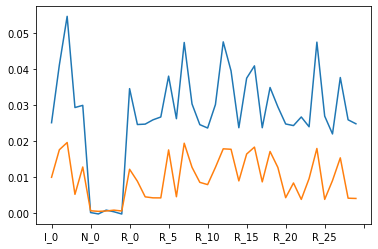

In [15]:
imp_point1['mean'].plot()
imp_point1['std'].plot()

0.8785999999999999


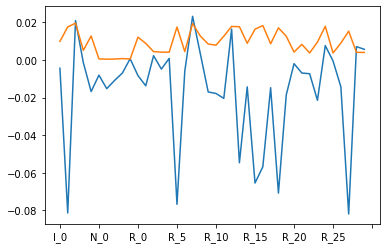

In [17]:
from sklearn.metrics import accuracy_score

def featImpMDAPWA(clf,X,y,n_splits=10):
# feat importance based on OOS score reduction
    cvGen=KFold(n_splits=n_splits) 
    scr0,scr1=pd.Series(),pd.DataFrame(columns=X.columns) 
    for i,(train,test) in enumerate(cvGen.split(X=X)):
        X0,y0=X.iloc[train,:],y.iloc[train] 
        X1,y1=X.iloc[test,:],y.iloc[test] 
        fit=clf.fit(X=X0,y=y0)
        pred=fit.predict(X1)
        scr0.loc[i]=accuracy_score(y1,pred)
        for j in X.columns:
            X1_=X1.copy(deep=True) 
            np.random.shuffle(X1_[j].values) # shuffle one column 
            pred=fit.predict(X1_) 
            scr1.loc[i,j]=accuracy_score(y1,pred)
    imp=(-1*scr1).add(scr0,axis=0) 
    imp=imp/(1.-scr1) 
    imp=pd.concat({'mean':imp.mean(),'std':imp.std()*imp.shape[0]**-.5},axis=1) # CLT 
    print(scr0.mean())
    return imp
imp_point1PWA=featImpMDAPWA(clf,X,y,10)
imp_point1PWA['mean'].plot()
imp_point1['std'].plot()

Notice how the noise features are close to zero and there are negative scores meaning the feature can be deterimental to the signal and possible out of sample forecasting.

Chapter 7 

In [11]:
import warnings
warnings.filterwarnings("ignore")
def optPort(cov,mu=None): 
    inv=np.linalg.inv(cov)
    ones=np.ones(shape=(inv.shape[0],1)) 
    if mu is None:mu=ones
    w=np.dot(inv,mu)
    w/=np.dot(ones.T,w)
    return w
def deNoiseCov(cov0,q,bWidth):
    corr0=cov2corr(cov0)
    eVal0,eVec0=getPCA(corr0)
    eMax0,var0=findMaxEval(np.diag(eVal0),q,bWidth)
    nFacts0=eVal0.shape[0]-np.diag(eVal0)[::-1].searchsorted(eMax0)
    corr1=denoisedCorr(eVal0,eVec0,nFacts0) 
    cov1=corr2cov(corr1,np.diag(cov0)**.5)
    return cov1
def corr2cov(corr,std): 
    cov=corr*np.outer(std,std)
    return cov

In [8]:
from scipy.linalg import block_diag
from sklearn.covariance import LedoitWolf
def formBlockMatrix(nBlocks,bSize,bCorr): 
    block=np.ones((bSize,bSize))*bCorr 
    block[range(bSize),range(bSize)]=1 
    corr=block_diag(*([block]*nBlocks)) 
    return corr
def formTrueMatrix(nBlocks,bSize,bCorr):
    corr0=formBlockMatrix(nBlocks,bSize,bCorr) 
    corr0=pd.DataFrame(corr0)
    cols=corr0.columns.tolist()
    np.random.shuffle(cols) 
    corr0=corr0[cols].loc[cols].copy(deep=True) 
    std0=np.random.uniform(.05,.2,corr0.shape[0]) 
    cov0=corr2cov(corr0,std0) 
    mu0=np.random.normal(std0,std0,cov0.shape[0]).reshape(-1,1)
    return mu0,cov0
def simCovMu(mu0,cov0,nObs,shrink=False):
    x=np.random.multivariate_normal(mu0.flatten(),cov0,size=nObs) 
    mu1=x.mean(axis=0).reshape(-1,1)
    if shrink:cov1=LedoitWolf().fit(x).covariance_
    else:cov1=np.cov(x,rowvar=0)
    return mu1,cov1
def optPort_nco(cov,mu=None,maxNumClusters=None): 
    cov=pd.DataFrame(cov)
    if mu is not None:mu=pd.Series(mu[:,0]) 
    corr1=cov2corr(cov) 
    corr1,clstrs,_=clusterKMeansBase(corr1,maxNumClusters,n_init=10)
    wIntra=pd.DataFrame(0,index=cov.index,columns=clstrs.keys()) 
    for i in clstrs:
        cov_=cov.loc[clstrs[i],clstrs[i]].values
        if mu is None:mu_=None 
        else:mu_=mu.loc[clstrs[i]].values.reshape(-1,1) 
        wIntra.loc[clstrs[i],i]=optPort(cov_,mu_).flatten()
    cov_=wIntra.T.dot(np.dot(cov,wIntra)) # reduce covariance matrix 
    mu_=(None if mu is None else wIntra.T.dot(mu)) 
    wInter=pd.Series(optPort(cov_,mu_).flatten(),index=cov_.index)
    nco=wIntra.mul(wInter,axis=1).sum(axis=1).values.reshape(-1,1) 
    return nco

In [9]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples 

def clusterKMeansBase(corr0,maxNumClusters=10,n_init=10):
    x,silh=((1-corr0.fillna(0))/2.)**.5,pd.Series()# observations matrix 
    for init in range(n_init):
        for i in range(2,maxNumClusters+1): 
            kmeans_=KMeans(n_clusters=i,n_jobs=1,n_init=1) 
            kmeans_=kmeans_.fit(x) 
            silh_=silhouette_samples(x,kmeans_.labels_) 
            stat=(silh_.mean()/silh_.std(),silh.mean()/silh.std())
            if np.isnan(stat[1]) or stat[0]>stat[1]: 
                silh,kmeans=silh_,kmeans_
    newIdx=np.argsort(kmeans.labels_) 
    corr1=corr0.iloc[newIdx] # reorder rows
    corr1=corr1.iloc[:,newIdx] # reorder columns
    clstrs={i:corr0.columns[np.where(kmeans.labels_==i)[0]].tolist()
        for i in np.unique(kmeans.labels_) } # cluster members
    silh=pd.Series(silh,index=x.index)
    return corr1,clstrs,silh
def cov2corr(cov):
# Derive the correlation matrix from a covariance matrix
    std=np.sqrt(np.diag(cov))
    corr=cov/np.outer(std,std) 
    corr[corr<-1],corr[corr>1]=-1,1 # numerical error 
    return corr

In [11]:
#data generating process
nBlocks,bSize,bCorr = 10,50,.5 
np.random.seed(0) 
mu0,cov0=formTrueMatrix(nBlocks,bSize,bCorr)

#unshrunk data
nObs,nSims,shrink,minVarPortf=1000,1000,False,True 
np.random.seed(0)
w1=pd.DataFrame(columns=range(cov0.shape[0]),index=range(nSims),dtype=float) 
w1_d=w1.copy(deep=True)
for i in range(nSims):
    mu1,cov1=simCovMu(mu0,cov0,nObs,shrink=shrink) 
    if minVarPortf:mu1=None 
    w1.loc[i]=optPort(cov1,mu1).flatten() 
    w1_d.loc[i]=optPort_nco(cov1,mu1,10).flatten()
w0=optPort(cov0,None if minVarPortf else mu0) 
w0=np.repeat(w0.T,w1.shape[0],axis=0) # true allocation 
rmsd=np.mean((w1-w0).values.flatten()**2)**.5 # RMSE 
rmsd_d=np.mean((w1_d-w0).values.flatten()**2)**.5 # RMSE

In [12]:
print('optPort',rmsd,'Nco',rmsd_d)

optPort 0.00494120598279739 Nco 0.0012956813556654857


In [13]:
def getRndCov(nCols,nFacts): 
  w=np.random.normal(size=(nCols,nFacts))
  cov=np.dot(w,w.T) # random cov matrix, however not full rank 
  cov+=np.diag(np.random.uniform(size=nCols)) # full rank cov 
  return cov
#data generating process without cluster structure
alpha,nCols,nFact,q=.995,500,100,5 
cov=np.cov(np.random.normal(size=(nCols*q,nCols)),rowvar=0)
cov=alpha*cov+(1-alpha)*getRndCov(nCols,nFact) # noise+signal 
corr0=cov2corr(cov)
std0=np.random.uniform(.05,.2,corr0.shape[0]) 
cov0=corr2cov(corr0,std0) 
mu0=np.random.normal(std0,std0,cov0.shape[0]).reshape(-1,1)
#shrunk data
nObs,nSims,shrink,minVarPortf=1000,1000,True,True 
np.random.seed(0)
w1=pd.DataFrame(columns=range(cov0.shape[0]),index=range(nSims),dtype=float) 
w1_d=w1.copy(deep=True)
for i in range(nSims):
    mu1,cov1=simCovMu(mu0,cov0,nObs,shrink=shrink) 
    if minVarPortf:mu1=None 
    w1.loc[i]=optPort(cov1,mu1).flatten() 
    w1_d.loc[i]=optPort_nco(cov1,mu1,10).flatten()
w0=optPort(cov0,None if minVarPortf else mu0) 
w0=np.repeat(w0.T,w1.shape[0],axis=0) # true allocation 
rmsdwocs=np.mean((w1-w0).values.flatten()**2)**.5 # RMSE 
rmsd_dwocs=np.mean((w1_d-w0).values.flatten()**2)**.5 # RMSE'''

In [14]:
print('optPort',rmsdwocs,'Nco',rmsd_dwocs)

optPort 0.00145601353691189 Nco 0.0014301947633717474


In [15]:
#data generating process for size 10
nBlocks,bSize,bCorr =5,2,.5 
np.random.seed(0) 
mu0,cov0=formTrueMatrix(nBlocks,bSize,bCorr)

#shrunk data
nObs,nSims,shrink,minVarPortf=1000,1000,True,True 
np.random.seed(0)
w1=pd.DataFrame(columns=range(cov0.shape[0]),index=range(nSims),dtype=float) 
w1_d=w1.copy(deep=True)
for i in range(nSims):
    mu1,cov1=simCovMu(mu0,cov0,nObs,shrink=shrink) 
    if minVarPortf:mu1=None 
    w1.loc[i]=optPort(cov1,mu1).flatten() 
    w1_d.loc[i]=optPort_nco(cov1,mu1,int(cov0.shape[0]/2)).flatten()
w0=optPort(cov0,None if minVarPortf else mu0) 
w0=np.repeat(w0.T,w1.shape[0],axis=0) # true allocation 
rmsdten=np.mean((w1-w0).values.flatten()**2)**.5 # RMSE 
rmsd_dten=np.mean((w1_d-w0).values.flatten()**2)**.5 # RMSE

In [16]:
print('optPort',rmsdten,'Nco',rmsd_dten)

optPort 0.014096149480827973 Nco 0.01241536750568695


In [12]:
#data generating process for size 100
nBlocks,bSize,bCorr = 5,20,.5 
np.random.seed(0) 
mu0,cov0=formTrueMatrix(nBlocks,bSize,bCorr)
#shrunk data
nObs,nSims,shrink,minVarPortf=1000,1000,True,True 
np.random.seed(0)
w1=pd.DataFrame(columns=range(cov0.shape[0]),index=range(nSims),dtype=float) 
w1_d=w1.copy(deep=True)
for i in range(nSims):
    mu1,cov1=simCovMu(mu0,cov0,nObs,shrink=shrink) 
    if minVarPortf:mu1=None 
    w1.loc[i]=optPort(cov1,mu1).flatten() 
    w1_d.loc[i]=optPort_nco(cov1,mu1,10).flatten()
w0=optPort(cov0,None if minVarPortf else mu0) 
w0=np.repeat(w0.T,w1.shape[0],axis=0) # true allocation 
rmsdhund=np.mean((w1-w0).values.flatten()**2)**.5 # RMSE 
rmsd_dhund=np.mean((w1_d-w0).values.flatten()**2)**.5 # RMSE

In [13]:
print('optPort',rmsdhund,'Nco',rmsd_dhund)

optPort 0.007030181124454848 Nco 0.004045734626070349


The nested clustered optimization algorithm efficiently deals with Markowitz’s curse outperforming the Marlowitz's solution everytime

Chapter 8 
Consider an investment strategy that buys S&P 500 futures when a price moving average with a short lookback exceeds a price moving average with a
longer lookback

In [48]:
import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

gamma = 0.5772156649015328606
e = np.exp(1)

# analytical formula for expected maximum sharpe ratio
def approximate_expected_maximum_sharpe(mean_sharpe, var_sharpe, n_trials):
    return mean_sharpe + np.sqrt(var_sharpe) * ((1 - gamma) * norm.ppf(1 - 1 / n_trials) + gamma * norm.ppf(1 - 1 / (n_trials * e)))

In [54]:
n_samples = 10000
n_trials = 100 

mean_sharpe = 0
var_sharpe = 1 / 252
std_sharpe = np.sqrt(var_sharpe)

formula_expected_max_sharpe = approximate_expected_maximum_sharpe(mean_sharpe,var_sharpe,n_trials)

print("Formula Expected Maximum Sharpe Ratio (annualized): ",formula_expected_max_sharpe * np.sqrt(252))

sharpe_estimates = np.random.normal(0, std_sharpe, (n_samples, n_trials))
maxSR = np.mean([max(sharpe_estimates[sample,]) * np.sqrt(252) for sample in range(n_samples)])

print("Empirical Expected Maximum Sharpe Ratio (annualized): ", maxSR)


Formula Expected Maximum Sharpe Ratio (annualized):  2.530602893201685
Empirical Expected Maximum Sharpe Ratio (annualized):  2.50497907017055


In [59]:
def compute_deflated_sharpe_ratio(*,
                                  estimated_sharpe,
                                  sharpe_variance,
                                  n,
                                  backtest_horizon,
                                  skew,
                                  kurtosis):
    SR0 = approximate_expected_maximum_sharpe(0, sharpe_variance, n_trials)
    
    return norm.cdf(((estimated_sharpe - SR0) * np.sqrt(backtest_horizon - 1)) / np.sqrt(1 - skew * estimated_sharpe + ((kurtosis - 1) / 4) * estimated_sharpe**2))

Using our the empirical expected sharpe ratio I used my data from a strategy I created lets find the probability of observing a Sharpe ratio equal to or higher than zero (a profit)

compute_deflated_sharpe_ratio(estimated_sharpe=maxSR/np.sqrt(252),sharpe_variance=var_sharpe,n=100,backtest_horizon=1000,skew=-1.17370691143265,kurtosis=5.5251478363041)


Definitely needs improvment for the long run